# Feeling Wheel Atlas

This notebook demonstrates the use of the captum.optim submodule for the creation of Feeling Wheel Atlases for the CLIP ResNet 50x4 model from OpenAI.

In [ ]:
%load_ext autoreload
%autoreload 2

import copy
import time
from typing import Callable, Dict, List, Optional, Tuple, Union

import captum.optim as opt
import torch
import torch.nn.functional as F
from captum.optim.models import clip_resnet50x4_text, clip_resnet50x4_image
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setup

We start off by defining a variety of helper functions to aid in creating our atlas visualizations.

In [ ]:
LossFunction = Callable[[Dict[torch.nn.Module, Optional[torch.Tensor]]], torch.Tensor]


def get_facet_weights(facet: str) -> List[torch.Tensor]:
    """
    Select from a list of pretrained facets of different themes / concepts. This
    function returns pretrained facets for the CLIP ResNet 50x4 model's
    `layer3[0].relu3`, `layer3[2].relu3`, `layer3[4].relu3`, `layer3[6].relu3`, &
    `layer3[8].relu3` layers.

    The pretrained facets were created by training linear probes to discriminate
    between images from a certain concept / theme, and generic natural images.

    Choices are one of:
        "face" for close ups of human faces.
        "text" for text symbols like letters and numbers.
        "logo" for organization / group symbols & designs.
        "pose" for humans in various poses.
        "arch" for architecture.
        "nature" for outdoors and nature.
        "indoor" for building interiors.

    Args:

        facet (str): The desired set of facets to use for the CLIP ResNet 50x4 model's
            lower layers. See above for the valid choices.

    Returns:
        facets (list of torch.Tensor): A list of facets for the lower layers.
    """
    facet_list = ["face", "text", "logo", "pose", "arch", "nature", "indoor"]
    assert facet in facet_list
    idx = facet_list.index(facet)
    url = "https://pytorch.s3.amazonaws.com/models/captum/clip_resnet50x4_facets.pt"
    facets_weights = torch.hub.load_state_dict_from_url(
        url, progress=True, check_hash=False
    )[idx]
    return facets_weights


def setup_channel_facet_objective(
    channel_vecs: torch.Tensor,
    model: torch.nn.Module,
    facet: Union[str, List[torch.Tensor]] = "face",
    device: torch.device = torch.device("cpu"),
    strength: Union[float, List[float]] = 3.3667,
    ultimate_target: Optional[torch.nn.Module] = None,
    lower_target_layers: Optional[List[torch.nn.Module]] = None,
) -> LossFunction:
    """
    Render a set of channels or vectors with a chosen facet.

    Args:

        channel_vecs (torch.Tensor): A list set of channel direction vectors stacked
            across the batch dimension. If only a single channel vector is given, then
            no batch targeting will be used.
        model (nn.Module): A PyTorch model instance.
        facet (str or list of torch.Tensor, optional): The desired facet theme / concept
            to use for facet loss. To use the available pretrained facets trained on
            the ResNet 50x4 model, choose one of; "face", "text", "logo", "pose",
            "arch", "nature", or "indoor". For custom facets, use a list of tensors
            that correspond to the lower_target_layers.
            Default: "face"
        device (torch.device, optional): The device to use.
            Default: torch.device("cpu")
        strength (float, list of float, optional): A single float or list of floats to
            use for batch dimension weighting. If using a single value, then it will
            be applied to all batch dimensions equally. Otherwise a list of floats
            with a shape of: [start, end] should be used for torch.linspace to
            calculate the step values in between. Set to None for no weighting.
            Default: 3.3667
        ultimate_target (nn.Module, optional): The main target layer that we are
            visualizing targets from. This is normally the penultimate layer of the
            model.
            Default: model.layer4[5]
        lower_target_layers (list of nn.Module, optional): A list of lower target
            layers that we have facet weights for, to use in the FacetLoss objectives.
            These target layers should be below the ultimate_target layer in the
            model.
            Default: [model.layer3[0].relu3, model.layer3[2].relu3,
            model.layer3[4].relu3, model.layer3[6].relu3, model.layer3[8].relu3]

    Returns:
        loss_fn (LossFunction): A loss objective ready for use.
    """
    # Main target layer
    ultimate_target = ultimate_target or model.layer4[-1]

    if channel_vecs.dim() == 1:
        channel_vecs = channel_vecs.unsqueeze(0)
        assert channel_vecs.dim() == 2

    # Determine whether or not batch targeting is required
    use_batch = channel_vecs.dim() > 1

    # Setup main target losses
    loss_fn_list, vec_list = [], []

    for b, v in enumerate(channel_vecs):
        assert v.dim() == 1
        channel_vec = v.to(device)
        vec_loss_fn = opt.loss.VectorLoss(
            target=ultimate_target,
            vec=channel_vec,
            batch_index=b if use_batch else None,
        )
        loss_fn_list.append(vec_loss_fn)
        vec_list.append(channel_vec)

    # Load facet weights
    if isinstance(facet, str):
        facet_weights = get_facet_weights(facet)
        facet_weights = [x.to(device) for x in facet_weights]
    else:
        assert all([isinstance(t, torch.Tensor) for t in facet])
        facet_weights = [x.to(device) for x in facet]

    # Lower target layers
    lower_target_layers = lower_target_layers or [
        model.layer3[0].relu3,
        model.layer3[2].relu3,
        model.layer3[4].relu3,
        model.layer3[6].relu3,
        model.layer3[8].relu3,
    ]

    assert len(lower_target_layers) == len(facet_weights)

    # Setup Facet Losses for all of the lower layers
    batch_facet_loss_fn_list = []
    for b, vec in enumerate(vec_list):
        facet_loss_fn_list = [
            opt.loss.FacetLoss(
                vec=vec,
                ultimate_target=ultimate_target,
                layer_target=layer_target,
                strength=strength,
                facet_weights=f_weights,
                batch_index=b if use_batch else None,
            )
            for layer_target, f_weights in zip(lower_target_layers, facet_weights)
        ]
        batch_facet_loss_fn_list += facet_loss_fn_list
    return opt.loss.sum_loss_list(loss_fn_list + batch_facet_loss_fn_list)


def visualize(
    model: torch.nn.Module,
    image: opt.images.ImageParameterization,
    loss_fn: opt.loss.Loss,
    lr: float = 0.008,
    n_iter: int = 256,
    alpha: bool = False,
) -> None:
    """
    Args:

        model (nn.Module): A PyTorch model instance.
        image (ImageParameterization): A Captum ImageParameterization instance.
        loss_fn (LossFunction): A Captum loss function instance.
        lr (float, optional): The learning rate to use with the Adam optimizer.
            Default: 0.008
        n_iter (int, optional): The number of iterations to perform optimization for.
            Default: 256
        alpha (bool, optional): Whether or not to optimize with transparency.
            Default: False
    """
    # Define our transforms
    transforms = opt.transforms.TransformationRobustness(crop_or_pad_output=True)
    if alpha:
        transforms = torch.nn.Sequential(transforms, opt.transforms.BlendAlpha())
        loss_fn = loss_fn + (
            opt.loss.L2Mean(transforms[0], channel_index=3, constant=0.0) ** 0.5
        )
    obj = opt.InputOptimization(model, loss_fn, image, transform=transforms)
    history = obj.optimize(opt.optimization.n_steps(n_iter), lr=lr)


def render_batch(
    vecs: torch.Tensor,
    model: torch.nn.Module,
    device: torch.device = torch.device("cpu"),
    alpha: bool = False,
    facet: Union[str, List[torch.Tensor]] = "face",
) -> List[torch.Tensor]:
    """
    Batch direction vector rendering function.

    Args:

        vecs (torch.tensor): A set of direction vectors to render, with a
            shape of: [num_vecs, num_channels]
        model (nn.Module): A PyTorch model instance.
        device (torch.device, optional): The device to use.
            Default: torch.device("cpu")
        alpha (bool, optional): Whether or not to optimize with transparency.
            Default: False
        facet (str or list of torch.Tensor, optional): The desired facet theme / concept
            to use for facet loss. To use the available pretrained facets trained on
            the ResNet 50x4 model, choose one of; "face", "text", "logo", "pose",
            "arch", "nature", or "indoor". For custom facets, use a list of tensors
            that correspond to the lower_target_layers.
            Default: "face"

    Returns:
        images (list of torch.Tensor): A list of rendered images corresponding to the
            input direction vectors.
    """
    assert vecs.dim() == 2
    # Use "face" facets
    loss_fn = setup_channel_facet_objective(
        channel_vecs=vecs, model=model, facet=facet, device=device, strength=3.3667
    )

    # Setup image parameterization
    channels = 3 if not alpha else 4
    image = opt.images.NaturalImage(
        (288, 288), batch=vecs.shape[0], channels=channels
    ).to(device)

    # L2 Penalty to improve visualization
    loss_fn = loss_fn - (10.0 * opt.loss.L2Mean(image))

    # Render the visualizations
    visualize(model, image, loss_fn, lr=0.008, n_iter=256, alpha=alpha)

    images = image().detach()
    return [images[t : t + 1, ...].clone() for t in range(vecs.shape[0])]


def create_alpha_mask(
    h: int,
    w: int,
    coords: List[Union[Tuple[int, int, int], Tuple[int, int]]],
    grid_size: Tuple[int, int],
    device: torch.device = torch.device("cpu"),
) -> torch.tensor:
    """
    Create an alpha mask to make an atlas background transparent.

    Args:

       h (int): The height of each cell.
       w (int): the width of each cell.
       coords (List[Union[Tuple[int, int, int], Tuple[int, int]]]): A list of
           atlas coordinates to use for creating the mask.
       grid_size (Tuple[int, int]): The grid_size of grid cells to use. The grid_size
           variable should be in the format of: [width, height].
       device (torch.device, optional): The device that the cells are on.
           Default: torch.device("cpu")

    Returns:
       alpha_mask (torch.Tensor): An alpha mask tensor used to make an atlas
           background transparent.
    """

    return opt.atlas.create_atlas(
        [torch.ones(1, 1, h, w, device=device) for _ in coords],
        coords,
        grid_size=grid_size,
        base_tensor=torch.zeros,
    )

## Dataset: The Feeling Wheel Construct

Psychologists have spent years researching how to organize human feelings, and have identified a number of larger structures that appear across cultures & regions. For this tutorial, we'll use the 'feeling wheel' structure for analyzing our model. The research paper's authors have already organized their feeling wheel words into a 2D structure, and thus we don't have to perform any calculations for determining the shape. Each word will get its own atlas grid cell. All we need to do is collect, sort, and render each of the items in the feeling wheel.

The list of feelings below is based on [The Feeling Wheel: A Tool for Expanding Awareness of Emotions and Increasing Spontaneity and Intimacy](https://doi.org/10.1177/036215378201200411), and more modern Emotion Vocabulary Wheels like [this one](https://observablehq.com/@mbostock/emotion-wheel). We will use this list of feelings as our input data for analyzing the CLIP model.

In [ ]:
emotion_wheel = [
    "aroused", "inspired", "insecure", "sad", "victimized", "eager", "weak",
    "insignificant", "repelled", "energetic", "worried", "hurt", "abandoned", "awful",
    "empty", "exposed", "hesitant", "busy", "fearful", "helpless", "let down",
    "remorseful", "sensitive", "nauseated", "guilty", "jealous", "proud", "rushed",
    "frightened", "anxious", "despair", "grief", "fragile", "bad", "distant",
    "intimate", "successful", "inquisitive", "courageous", "nervous", "surprised",
    "overwhelmed", "amazed", "out of control", "embarrassed", "violated", "lonely",
    "loving", "interesting", "curious", "thankful", "astonished", "startled", "scared",
    "appalled", "confused", "worthless", "isolated", "numb", "rejected", "creative",
    "inadequate", "peaceful", "respected", "excited", "shocked", "horrified",
    "excluded", "disrespected", "humiliated", "judgmental", "skeptical", "detestable",
    "valued", "confident", "tired", "happy", "hopeful", "accepted", "joyful",
    "dismissive", "annoyed", "disappointed", "bored", "depressed", "stressed",
    "dismayed", "unfocused", "optimistic", "trusting", "content", "resentful",
    "disapproving", "disillusioned", "apathetic", "indifferent", "betrayed", "sleepy",
    "withdrawn", "free", "awe", "cheeky", "frustrated", "ashamed", "indignant",
    "critical", "perplexed", "aggressive", "revolted", "persecuted", "playful",
    "pressured", "infuriated", "disgusted", "threatened", "provoked", "powerful",
    "furious", "angry", "mad", "hostile"]

### The Dataset Shape

We can easily view the 2D spherical shape of the feeling wheel data that we wish to visualize as an atlas like so.

In [ ]:
# Num cells per row
n_cells = [3, 7, 9, 11, 11, 13]
n_cells = n_cells + [13] + n_cells[::-1]


c = 0
for n in n_cells:
    c += n
    n_cells = ", ".join(emotion_wheel[c-n:c])
    print(n_cells.center(137, " "))

                                                       aroused, inspired, insecure                                                       
                                     sad, victimized, eager, weak, insignificant, repelled, energetic                                    
                                 worried, hurt, abandoned, awful, empty, exposed, hesitant, busy, fearful                                
                helpless, let down, remorseful, sensitive, nauseated, guilty, jealous, proud, rushed, frightened, anxious                
                 despair, grief, fragile, bad, distant, intimate, successful, inquisitive, courageous, nervous, surprised                
 overwhelmed, amazed, out of control, embarrassed, violated, lonely, loving, interesting, curious, thankful, astonished, startled, scared
     appalled, confused, worthless, isolated, numb, rejected, creative, inadequate, peaceful, respected, excited, shocked, horrified     
    excluded, disrespected, humili

## Atlas Setup

### The CLIP Tokenizer

We setup the tokenizer for the CLIP model.

In [ ]:
clip_tokenizer = opt.transforms.CLIPTokenizer(pretrained_merges=True)

### Sample Collection

To create the emotion wheel atlas, we first need to collect samples using our list of feelings. To do this, we will use 3 different prompts for each emotion / feeling word to ensure we have enough data.

To collect the samples, we first set up a class to help combine the image and text portions of our model into a single model. We then collect attributions for the target layer for different text inputs, while setting the image inputs to be all zeros. 

In [ ]:
class CLIP_ResNet50x4(torch.nn.Module):
    def __init__(
        self, image_model: torch.nn.Module, text_model: torch.nn.Module
    ) -> None:
        """
        Args:

            image_model (nn.Module): A PyTorch model instance that takes image inputs.
            text_model (nn.Module): A PyTorch model instance that takes text inputs.
        """
        super().__init__()
        self.image_model = image_model
        self.text_model = text_model

    def forward(
        self, x: Union[Tuple[torch.Tensor, torch.Tensor], List[torch.Tensor]]
    ) -> torch.Tensor:
        """
        Args:

            x (tuple or list of torch.Tensor): A tuple or list of tensors, with the
                format: [image_tensor, text_tensor].

        Returns:
            logits_per_text (torch.Tensor): The model output.
        """
        assert len(x) == 2
        image, text = x
        image_features = self.image_model(image)
        text_features = self.text_model(text)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.text_model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()
        return logits_per_text


def get_text_layer_attr(
    model: torch.nn.Module, layer_target: torch.nn.Module, text_inputs: torch.Tensor
) -> torch.Tensor:
    """
    Args:

        model (nn.Module): A PyTorch model instance.
        layer_target (nn.Module): A target layer instance.
        text_inputs (torch.Tensor): A text input to pass through the text portion of the
            model.

    Returns
        grad (torch.Tensor): Attributions for the target layer.
    """
    grad = []
    for i in range(text_inputs.shape[0]):
        model_inputs = (
            torch.nn.Parameter(torch.zeros(1, 3, 288, 288).to(text_inputs.device)),
            text_inputs[i : i + 1].clone(),
        )
        attr_activations = opt.models.collect_activations(
            model, [layer_target, model], model_inputs
        )
        target_activ = attr_activations[layer_target]
        logit_activ = attr_activations[model]
        grad_b = torch.autograd.grad(
            outputs=logit_activ,
            inputs=[target_activ],
            grad_outputs=torch.ones_like(logit_activ),
        )[0].detach()
        grad.append(grad_b)
    return torch.cat(grad, 0)


def collect_text_prompt_attr(
    full_clip_model: torch.nn.Module,
    target: torch.nn.Module,
    text_list: List[str],
    prompt_text: List[str] = ["", ""],
    batch_size: int = 8,
    device: torch.device = torch.device("cpu"),
) -> List[torch.Tensor]:
    """
    Collect attribution samples for a list of words with a specified prompt.

    Args:

        full_clip_model (nn.Module): A PyTorch model instance.
        target (nn.Module): A target layer instance.
        text_list (list of str): A list of words to use as inputs for the text portion
            of the full_clip_model.
        prompt_text (list of str, optional): Text strings to use for part 1 and part 2
            of the prompt, with words from text_list being placed in the middle.
            Default: ["", ""]
        batch_size (int, optional): The batch size to use when collected samples.
        device (torch.device, optional): The device to place model inputs on before
            sending them through the model.
            Default: torch.device("cpu")

    Returns:
        layer_attr (list of torch.Tensor): A set of layer attributions for the target
            layer.
        labels (list of int): A set of corresponding labels for the tensors in
            layer_attr.
    """
    label_idx = list(range(len(text_list)))
    text_activ, labels = [], []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_str = text_list[i : i + batch_size]
        batch_prompted = [prompt_text[0] + s + prompt_text[1] for s in batch_str]
        text_inputs = clip_tokenizer(batch_prompted).to(device)

        layer_activ = get_text_layer_attr(full_clip_model, target, text_inputs)
        if layer_activ.shape[0] > 1:
            text_activ = text_activ + [
                layer_activ[t : t + 1].clone() for t in range(layer_activ.shape[0])
            ]
            labels = labels + label_idx[i : i + batch_size]
        else:
            text_activ.append(layer_activ)
            labels.append(i)
    return text_activ, labels

We load both the image and text models, and then place them inside our `CLIP_ResNet50x4` wrapper class to create the full CLIP model.

In [ ]:
clip_model_text = clip_resnet50x4_text(pretrained=True).eval().to(device)
clip_model_image = (
    clip_resnet50x4_image(pretrained=True, replace_relus_with_redirectedrelu=False)
    .eval()
    .to(device)
)

# Create full CLIP model
clip_model_full = CLIP_ResNet50x4(clip_model_image, clip_model_text)

We collect samples from 3 different prompts for every feeling / emotion in the feeling wheel, as described in the paper [here](https://distill.pub/2021/multimodal-neurons/#d-footnote-41). Collecting 3 samples for each of the 121 words will give us a total of 363 samples.

In [ ]:
# Setup layer target
target = clip_model_full.image_model.layer4[5]

# Desired sample collection batch size
batch_size = 8


# Prompt 1, "i am feeling {emotion}"
prompt_text = ["i am feeling ", ""]
activation_samples_1, labels_1 = collect_text_prompt_attr(
    clip_model_full,
    target,
    text_list=emotion_wheel,
    prompt_text=prompt_text,
    batch_size=batch_size,
    device=device,
)

# Prompt 2, "Me feeling {emotion} on my face"
prompt_text = ["Me feeling ", " on my face"]
activation_samples_2, labels_2 = collect_text_prompt_attr(
    clip_model_full,
    target,
    text_list=emotion_wheel,
    prompt_text=prompt_text,
    batch_size=batch_size,
    device=device,
)

# Prompt 3, "a photo of me with a {emotion} expression on my face"
prompt_text = ["a photo of me with a ", " expression on my face"]
activation_samples_3, labels_3 = collect_text_prompt_attr(
    clip_model_full,
    target,
    text_list=emotion_wheel,
    prompt_text=prompt_text,
    batch_size=batch_size,
    device=device,
)


# Concatenate all 3 prompts & corresponding labels
activation_samples = activation_samples_1 + activation_samples_2 + activation_samples_3
activation_samples = torch.cat(activation_samples, 0)
activation_labels = torch.as_tensor(labels_1 + labels_2 + labels_3)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

### Filtering Samples with Sparse Logistic Regression


Now that we have collected our 3 prompt samples for each of the 121 words in our feeling wheel dataset, we need to reduce the number of samples from 363 back down to 121 (one for each word). To perform this reduction, we can train a logistic regression model on the samples. We also want to filter out neurons that aren't important to any of the words, and we do this by adding an L1 penalty to make our logistic regression sparse.

Below we define a helper function & class for training a sparse logistic regression model on our collected samples to determine the channels that maximally discriminate between the attribution vectors. An L1 penalty is used to make the logistic regression sparse, as it moves unimportant features towards zero. The weights of the resulting trained models will then provide us with the direction vector vectors that we need to visualize our feelings / emotions.

In [ ]:
def train_logistic_regression_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    num_epochs: int = 264,
    lr: float = 0.001,
    l1_weight: float = 0.0001,
    l2_weight: float = 0.0001,
    device: torch.device = torch.device("cpu"),
    verbose: bool = False,
) -> torch.Tensor:
    """
    Perform Sparse Logistic Regression for multiple classes faster than Scikit-learn.

    Args:

        model (nn.Module): An PyTorch model instance.
        dataloader (torch.utils.data.DataLoader): A PyTorch Dataloader instance.
        num_epochs (int, optional): The number of epochs to train for.
            Default: 264
        lr (float, optional): The desired learning rate to use with the SGD optimizer.
            Default: 0.001
        l1_weight (float, optional): The desired l1 penalty weight to use.
            Default: 0.0001
        l2_weight (float, optional): The desired l2 penalty weight to use.
            Default: 0.0001
        device (torch.device, optional): The device to place training inputs on before
            sending them through the model.
            Default: torch.device("cpu")
        verbose (bool, optional): Whether or not to print loss and accuracy after
            every epoch.
            Default: False

    Returns:
        weights (torch.Tensor): The weights of the best scoring model from the
            training session.
        best_acc (float): The training accuracy for the returned weights.
    """
    criterion = torch.nn.CrossEntropyLoss()
    start_time = time.time()
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, weight_decay=l2_weight
    )

    best_model, best_acc = copy.deepcopy(model), 0.0

    for epoch in tqdm(range(num_epochs)):
        if verbose:
            print("Epoch {}/{}".format(epoch + 1, num_epochs))
            print("-" * 12)

        epoch_loss, epoch_acc = 0.0, 0.0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.enable_grad():
                output = model(inputs)

                loss = criterion(output, labels)
                preds = torch.max(output, 1)[1]

                # L1 loss moves unimportant features towards zero
                if l1_weight != 0.0:
                    l1_penalty = l1_weight * model.weight.abs().sum()
                    total_loss = loss + l1_penalty
                else:
                    total_loss = loss

                total_loss.backward()
                optimizer.step()

            with torch.no_grad():
                epoch_loss += loss.item() * inputs.size(0)
                epoch_acc += torch.sum(preds == labels).detach()

        epoch_loss = epoch_loss / len(dataloader.dataset)
        epoch_acc = epoch_acc.double() / len(dataloader.dataset)

        if verbose:
            print("Loss: {:.4f} Acc: {:.4f}".format(epoch_loss, epoch_acc))
            time_elapsed = time.time() - start_time
            print(
                "  Time Elapsed {:.0f}m {:.0f}s\n".format(
                    time_elapsed // 60, time_elapsed % 60
                )
            )

        # Make sure we return the best model weights
        if epoch_acc > best_acc:
            best_model, best_acc = copy.deepcopy(model), epoch_acc

    # if verbose:
    print("Best Accuracy", best_acc.item())
    return best_model.weight.detach(), best_acc


class SampleDataset(torch.utils.data.Dataset):
    """Simple dataset for collected samples."""

    def __init__(self, data: torch.Tensor, labels: torch.Tensor) -> None:
        self.data = [data[i].clone() for i in range(data.shape[0])]
        self.labels = [labels[i].clone() for i in range(labels.shape[0])]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        return self.data[idx], self.labels[idx]

    def __len__(self) -> int:
        return len(self.data)

We can now train our sparse logistic regression model!

To improve the accuracy of our model, we'll use `torch.float64` instead of the default `torch.float32`. Using the 64-bit floating point is recommended and used by Scikit-learn to improve performance in its [Logistic Regression Implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


In [ ]:
# Flatten samples & cast to torch.float64
t_shape = activation_samples.shape
sample_data = activation_samples.reshape(t_shape[0], -1).double()

# Setup dataset
batch_size = 32
sample_dataset = SampleDataset(sample_data.cpu(), activation_labels.cpu())
dataloader = torch.utils.data.DataLoader(
    sample_dataset, batch_size=batch_size, num_workers=0, shuffle=True
)


# Setup params for training
num_attempts = 3
lr = 0.001
l1_weight = 0.0001
l2_weight = 0.0001
num_iters = 3000
num_epochs = int(num_iters / (len(dataloader.dataset) / batch_size))
num_classes = len(emotion_wheel)

sample_weights, sample_acc = [], []
for _ in range(num_attempts):
    # Setup model
    model = (
        torch.nn.Linear(sample_data.shape[1], num_classes, bias=False)
        .to(device)
        .double()
    )
    model.weight = torch.nn.Parameter(model.weight)

    # Train Logistic Regression Model
    weights, acc = train_logistic_regression_model(
        model,
        dataloader,
        num_epochs=num_epochs,
        lr=lr,
        l1_weight=l1_weight,
        l2_weight=l2_weight,
        device=device,
        verbose=False,
    )
    weights = weights.reshape(num_classes, *t_shape[1:])
    sample_weights.append(weights.float())
    sample_acc.append(acc)


# Use the best model weights
best_idx = sample_acc.index(max(sample_acc))
sample_weights = sample_weights[best_idx]
print("Best accuracy achieved", round(max(sample_acc).item() * 100.0, 4))

  0%|          | 0/264 [00:00<?, ?it/s]

Best Accuracy 0.9421487603305785


  0%|          | 0/264 [00:00<?, ?it/s]

Best Accuracy 0.9504132231404959


  0%|          | 0/264 [00:00<?, ?it/s]

Best Accuracy 0.9366391184573003
Best accuracy achieved 95.0413


### Atlas Vectors & Coordinates

As we mentioned at the start of the tutorial, our feeling wheel data has already been sorted into a circular shape where each word denotes an atlas grid cell. Therefore we only need to calculate the coordinates to use for each vector using the circular pattern.

In [ ]:
# Num cells per row
n_cells = [3, 7, 9, 11, 11, 13]
n_cells = n_cells + [13] + n_cells[::-1]
grid_size = [max(n_cells)] * 2

vec_coords = []
for column, row in enumerate(n_cells):
    no_cells = (grid_size[0] - row) // 2
    for i in range(row):
        vec_coords = vec_coords + [[no_cells + i, column]]

The direction vectors are extremely easy to create, as we only need to make the sample weights 2D by taking the mean of their height and width dimensions.

In [ ]:
# Create direction vectors
vecs = sample_weights.mean(dim=(2, 3))

# Normalize values
vecs = vecs / vecs.max()

### Atlas Structures

Now that we have our atlas coordinates setup, we can analyze how the atlas grid cells relate to one another according to the model. To do this, we can organize the atlas cells into multiple high level structures by using non-negative matrix factorization (NMF) dimensionality reduction to color cells.

The resulting feeling wheel groups can then be compared to the groups created by psychologists.

In [ ]:
def color_border(
    x: torch.Tensor, colors: torch.Tensor, border: int = 1
) -> torch.Tensor:
    """
    Give an NCHW image a border with a specified color.

    Args:

        x (torch.Tensor): An NCHW image tensor to add colored padding to.
        colors (torch.Tensor): A set of colors corresponding to the number of channels
            in the input image.
        border (int, optional): The size of the border to use.

    Returns:
        x (torch.Tensor): The NCHW image tensor with a colored border.
    """
    assert x.dim() == 4 and x.shape[1] == colors.shape[0]
    x_channels = [x[:, c : c + 1] for c in range(x.shape[1])]
    new_channels, pad = [], [border] * 4
    for x_channel, color_c in zip(x_channels, colors.tolist()):
        new_channels.append(F.pad(x_channel, pad, mode="constant", value=color_c))
    return torch.cat(new_channels, dim=1)


def color_images(
    images: torch.Tensor, group_colors: torch.Tensor, border: int = 1
) -> torch.Tensor:
    """
    Give a set of NCHW images borders with a specified color.

    Args:

        images (torch.Tensor): A set of NCHW image tensors stacked across the batch
            dimension to add colored padding to.
        colors (torch.Tensor): A set of colors corresponding to the number of channels
            in the input images, stacked across the batch dimension.
        border (int, optional): The size of the border to use.
    
    Returns:
        colored_images (torch.Tensor): The stack of NCHW image tensor with colored
            borders.
    """
    assert images.shape[0] == group_colors.shape[0]
    images = [images[i : i + 1, ...].clone() for i in range(images.shape[0])]
    A = []
    for img, colors in zip(images, group_colors):
        A.append(color_border(img, colors, border=border))
    return torch.cat(A, 0)


def get_sample_colors(samples: torch.Tensor, n_groups: int = 7) -> torch.Tensor:
    """
    Split samples into n_groups and then give each group a distinct color.

    Args:

        samples (torch.Tensor): A set of sample weights to reduce the channel
            dimensionality of to n_groups. Each group is then given its own distinct
            color.
        n_groups (int, optional): The number of groups to reduce the input samples to
            channel dimension to.

    Returns:
        sample_colors (torch.Tensor): A set of RGB colors stacked across the batch
            dimension which corresponds to the number of samples.

    """
    reducer = opt.reducer.ChannelReducer(n_groups, "NMF")

    # Make the input positive for one-sided NMF
    samples_posneg = opt.reducer.posneg(samples.cpu(), dim=1)

    spatial_factors = reducer.fit_transform(samples_posneg).to(samples.device)

    if spatial_factors.dim() == 4:
        spatial_factors = spatial_factors.mean(dim=(2, 3))

    # Get the top scoring group for each of the factors
    group_indices = [
        torch.argsort(spatial_factors[i], dim=0)[-1]
        for i in range(spatial_factors.shape[0])
    ]

    # Create distinct RGB colors for each group
    group_colors = [
        opt.hue_to_rgb(360 * i / n_groups, device=samples.device)
        for i in range(n_groups)
    ]

    # Give each sample an RGB color based its top scoring group
    return torch.stack([group_colors[idx] for idx in group_indices])


def color_atlas_renders(
    atlas_images: torch.Tensor,
    sample_weights: torch.Tensor,
    num_groups: int = 7,
    border: int = 10,
) -> torch.Tensor:
    """
    Add colored borders to rendered atlas images based on high level atlas structures.

    Args:
        atlas_images (torch.Tensor): A set of NCHW image tensors stacked across the
            batch dimension.
        sample_weights (torch.Tensor): A set of sample weights to reduce the channel
            dimensionality of to n_groups. Each group is then given its own distinct
            color.
        n_groups (int, optional): The number of groups to reduce the input samples to
            channel dimension to with NMF.
            Default: 7
        border (int, optional): The size of the colored borders to use.
            Default: 10

    Returns:
        colored_atlas_images (torch.Tensor): A set of atlas_images with colored
            borders.
    """
    assert atlas_images.dim() == 4
    group_colors = get_sample_colors(sample_weights, num_groups=num_groups)
    if atlas_images.shape[1] == 4:
        group_colors = torch.cat(
            [group_colors, torch.ones_like(group_colors)[:, 0:1]], 1
        )
    return color_images(atlas_images, group_colors, border=border)

**7 Factor Feeling Wheel Categorization**

A common way of organizing feeling wheel words is to split them into 7 different groups like a sort of pie chart.

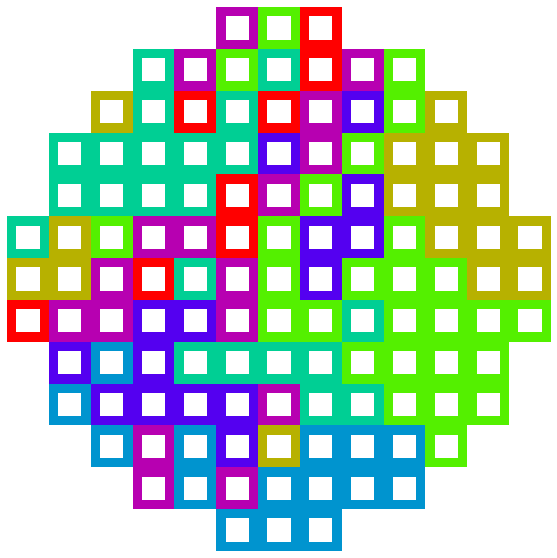

In [ ]:
# Create atlas cells
atlas_tensors = torch.ones(len(vec_coords), 3, 5, 5).to(device)

# Get atlas cell colors
c_factors = get_sample_colors(sample_weights, 7)

# Color atlas cells
colored_atlas = color_images(atlas_tensors, c_factors, border=2)

# Create atlas image
atlas_bw = opt.atlas.create_atlas(colored_atlas, vec_coords, grid_size=grid_size)

# Match atlas orientation to training data
atlas_bw = atlas_bw.rot90(2, [2, 3]).flip([3])

# Make background transparent
alpha_mask = create_alpha_mask(
    *colored_atlas.shape[2:],
    coords=vec_coords,
    grid_size=grid_size,
    device=atlas_bw.device
)
atlas_bw = torch.cat([atlas_bw, alpha_mask], 1)

# Show results
opt.images.show(atlas_bw, figsize=(10, 10))

**Emotion-Mood Axes (2 factors)**

Feeling wheels can also be organized into 2 groups for viewing the mood-axis divide.

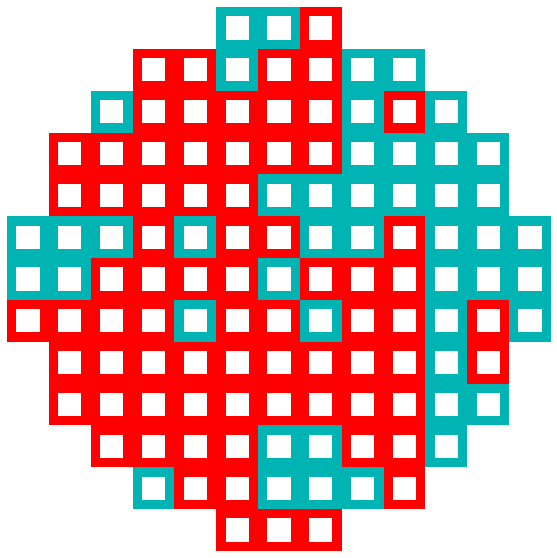

In [ ]:
# Create atlas cells
atlas_bw_tensors = torch.ones(len(vec_coords), 3, 5, 5).to(device)

# Get atlas cell colors
c_factors = get_sample_colors(sample_weights, 2)

# Color atlas cells
colored_atlas_bw = color_images(atlas_bw_tensors, c_factors, border=2)

# Create atlas image
atlas_bw = opt.atlas.create_atlas(colored_atlas_bw, vec_coords, grid_size=grid_size)

atlas_bw = atlas_bw.rot90(2, [2, 3]).flip([3])

# Make background transparent
alpha_mask = create_alpha_mask(
    *colored_atlas_bw.shape[2:],
    coords=vec_coords,
    grid_size=grid_size,
    device=atlas_bw.device
)
atlas_bw = torch.cat([atlas_bw, alpha_mask], 1)

# Show results
opt.images.show(atlas_bw, figsize=(10, 10))

## Rendering The Atlas Visualizations

We can now begin rendering our atlas images now using the sample data  that we collected, filtered, and prepared.

### Rendering

The CLIP ResNet 50x4 model performs best when image inputs have a height and width of `[288, 288]`, and thus memory requirements may exceed those of your device. Therefore, we'll render them in batches with the handy `render_batch` helper function that we defined at the start of this tutorial.

We now load the image portion of the CLIP ResNet 50x4 model with `RedirectedReLU` for visualization rendering.

In [ ]:
# Load the CLIP image model
clip_model = clip_resnet50x4_image(pretrained=True).eval().to(device)

We can now render the visualizations using our batch rendering function!

In [ ]:
use_alpha = False # Optionally optimize with transparency

batch_size = 4
atlas_images_list = []

for i in range(0, vecs.shape[0], batch_size):
    vecs_batch = vecs[i : i + batch_size].clone()
    imgs = render_batch(vecs_batch, clip_model, device=device, alpha=use_alpha)
    atlas_images_list += imgs

atlas_images = torch.cat(atlas_images_list, 0)

Just like with the colored atlas groups we created above, we can do the same with our fully rendered atlas.

In [ ]:
# Uncomment to color atlas image borders
# atlas_images = color_atlas_renders(
#     atlas_images, sample_weights=sample_weights, num_groups=7
# )

We can now create the feeling wheel atlas!

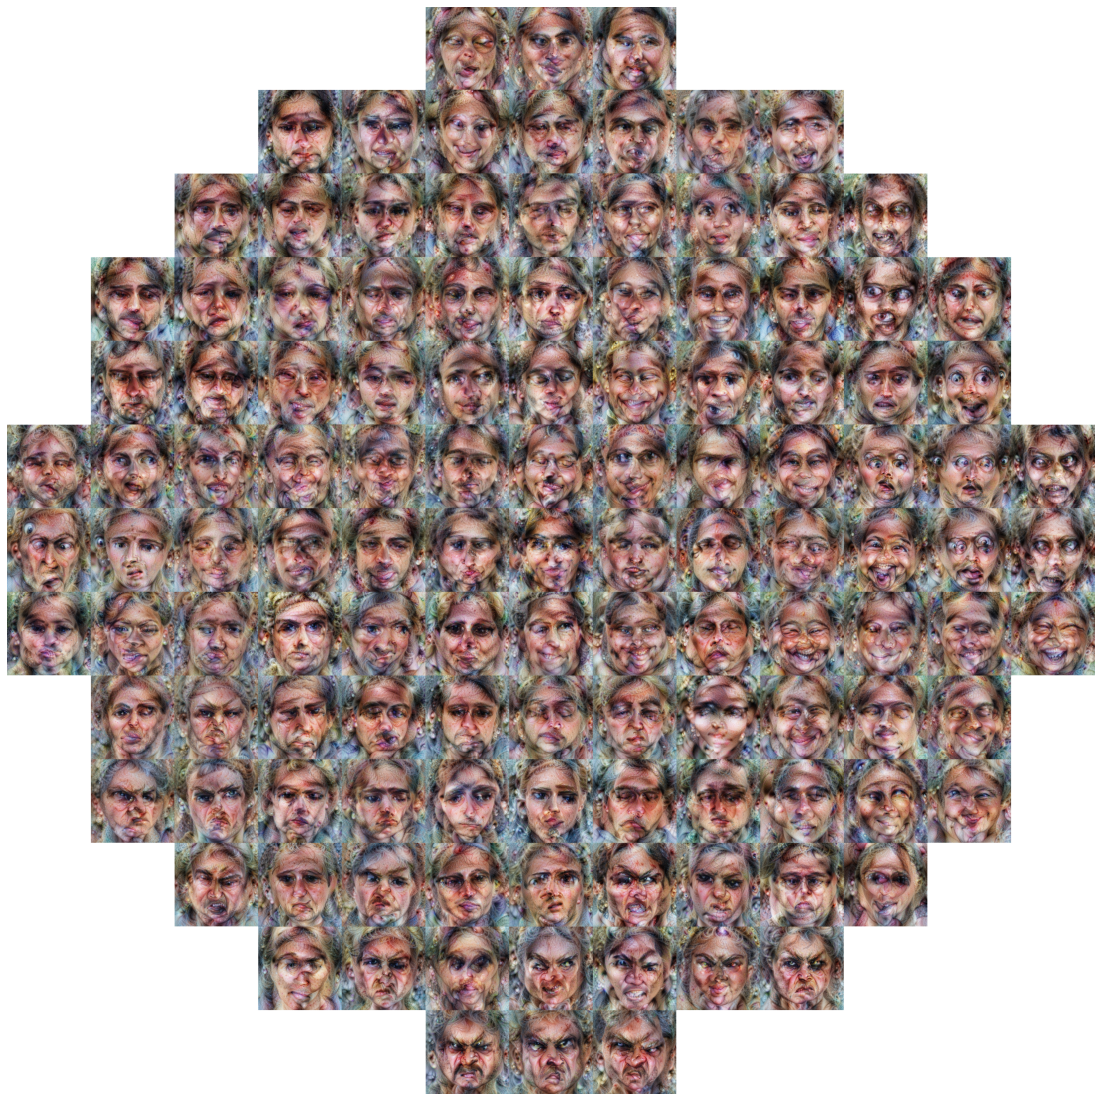

In [ ]:
# Build full atlas image
atlas_img = (
    opt.atlas.create_atlas(
        atlas_images.rot90(2, [2, 3]),
        # If for some reason we don't render all the atlas images, we can still build
        # the atlas by slicing off unused coordinates
        vec_coords[: atlas_images.shape[0]],
        grid_size=grid_size,
    )
    .rot90(2, [2, 3])
    .flip([3])
)


# Make background transparent
alpha_mask = create_alpha_mask(
    *atlas_images.shape[2:],
    coords=vec_coords,
    grid_size=grid_size,
    device=atlas_img.device
)

# Handle RGB & RGBA atlas images
if atlas_img.shape[1] == 3:
    atlas_img = torch.cat([atlas_img, alpha_mask], 1)
else:
    atlas_img = atlas_img * alpha_mask


# Save atlas as image and show it to user
opt.images.save_tensor_as_image(atlas_img.detach(), "feeling_wheel_atlas.png")
opt.images.show(atlas_img.detach(), figsize=(20, 20))

We can then compare our rendered images to the words they represent.

In [ ]:
# Num cells per row
n_cells = [3, 7, 9, 11, 11, 13]
n_cells = n_cells + [13] + n_cells[::-1]


c = 0
for n in n_cells:
    c += n
    n_cells = ", ".join(emotion_wheel[c - n : c])
    print(n_cells.center(137, " "))

                                                       aroused, inspired, insecure                                                       
                                     sad, victimized, eager, weak, insignificant, repelled, energetic                                    
                                 worried, hurt, abandoned, awful, empty, exposed, hesitant, busy, fearful                                
                helpless, let down, remorseful, sensitive, nauseated, guilty, jealous, proud, rushed, frightened, anxious                
                 despair, grief, fragile, bad, distant, intimate, successful, inquisitive, courageous, nervous, surprised                
 overwhelmed, amazed, out of control, embarrassed, violated, lonely, loving, interesting, curious, thankful, astonished, startled, scared
     appalled, confused, worthless, isolated, numb, rejected, creative, inadequate, peaceful, respected, excited, shocked, horrified     
    excluded, disrespected, humili